In [264]:
import medleydb as mdb
import os
import glob
import numpy as np
import librosa
import pandas as pd
import mir_eval
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Seed Detection Metrics

In [184]:
cd ../

/Users/rabitt/Dropbox/MARL/repos/motif


In [185]:
import motif

In [238]:
def get_ground_truth_contours(mtrack):

    mtrack.load_melody_annotations()
    data = np.array(mtrack.melody3_annotation)
    mel3 = data[:, 1:]
    times = data[:, 0]
    n_times, n_mels = mel3.shape

    c_index = []
    c_times = []
    c_freqs = []

    seeds = []
    idx = 0

    for mel_num in range(n_mels):
        nonzero = mel3[:, mel_num] > 0
        nonzero_diff = np.diff(nonzero.astype(int))

        contour_starts = list(np.where(nonzero_diff == 1)[0] + 1)
        contour_ends = list(np.where(nonzero_diff == -1)[0] + 1)

        if contour_ends[0] < contour_starts[0]:
            contour_starts.insert(0, 0)

        if len(contour_ends) < len(contour_starts):
            contour_ends.append(len(nonzero_diff))

        for s, e in zip(contour_starts, contour_ends):

            t = times[s:e]
            f = mel3[s:e, mel_num]

            contour_diff = np.abs(np.diff(mir_eval.melody.hz2cents(f)))

            splits = list(np.where(contour_diff > 50)[0] + 1)

            if len(splits) > 0:
                if splits[-1] == len(contour_diff):
                    splits = splits[:-1]
                split_starts = [0] + splits
                split_ends = splits + [len(t) - 1]

                for ss, se in zip(split_starts, split_ends):

                    tt = t[ss:se]
                    if len(tt) <= 1:
                        continue
                    ii = idx * np.ones(tt.shape)
                    idx += 1
                    ff = f[ss:se]
                    c_index.extend(ii)
                    c_times.extend(tt)
                    c_freqs.extend(ff)
                    seed_idx = int(round(len(tt)/2))
                    seeds.append([int(round(44100*tt[seed_idx])), ff[seed_idx]])

            else:
                if len(t) <= 1:
                    continue
                i = idx * np.ones(t.shape)
                idx += 1
                c_index.extend(i)
                c_times.extend(t)
                c_freqs.extend(f)
                seed_idx = int(round(len(t)/2))
                seeds.append([int(round(44100*t[seed_idx])), f[seed_idx]])

    c_index = np.array(c_index)
    c_times = np.array(c_times)
    c_freqs = np.array(c_freqs)

    sr = 44100.0/256.0
    ctr = motif.core.Contours(
        c_index, c_times, c_freqs, np.ones(c_index.shape), sr,
        '/Users/rabitt/Dropbox/MARL/mono/{}_MIX.wav'.format(mtrack.track_id)
    )
    return ctr, seeds

In [723]:
def evaluate_seeds(ctr, seeds, f_base=10):
    seed_array = np.array(seeds)
    seed_times = seed_array[:, 0]/44100.0
    seed_freqs = seed_array[:, 1]
    
    f_thresh = 30.0
    
    n_seeds = len(seed_times)
    n_contours = len(ctr.nums)
    num_true_positives = 0
    num_missed = 0
    
    for i in ctr.nums:
        t = ctr.contour_times(i)
        seeds_in_range = np.where(
            np.logical_and(seed_times >= t[0], seed_times <= t[-1]))[0]
        
        if len(seeds_in_range) > 0:
            f = ctr.contour_freqs(i)
            found_match = False
            for s in seeds_in_range:
                closest_time_idx = np.argmin(np.abs(t - seed_times[s]))
                if np.abs(seed_freqs[s] - f[closest_time_idx]) <= f_thresh:
                    num_true_positives += 1
                    found_match = True
                    break
            if not found_match:
                num_missed += 1
        else:
            num_missed += 1
                
    recall = float(num_true_positives) / float(n_contours)
    precision = float(num_true_positives) / float(n_seeds)
    f_score = (
        (1.0 + f_base**2.0) * (precision * recall) / ((f_base**2.0 * precision) + recall)
    )

    return recall, precision, f_score

# Seed Detection Param Sweep

In [158]:
def norm_matrix(mat, overall=True, time=True, freq=True):
    if overall:
        mat = mat - np.min(mat)
        m = np.max(mat)
        if m == 0:
            m = 1
        mat = mat/m
    
    if time:
        mat = (mat.T - np.min(mat, axis=1)).T
        m = np.max(mat, axis=1)
        m[m==0] = 1
        mat = (mat.T / m).T
    
    if freq:
        mat = mat - np.min(mat, axis=0)
        m = np.max(mat, axis=0)
        m[m==0] = 1
        mat = mat / m
    
    return mat

In [70]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [486]:
def detect_seeds(y, fs, hpss=False, quartertone=False, hop_size=4096, filter_scale=4,
                 avg_filt_len=6, peak_thresh=0.2, pre_max=3, post_max=3,
                 pre_avg=3, post_avg=3, delta=0.02, wait=2):

    if hpss:
        y = librosa.effects.harmonic(y)

    fmin = librosa.note_to_hz('E1')
    bins_per_octave = 24 if quartertone else 12
    n_cqt_bins = bins_per_octave * 6
    cqt = np.abs(librosa.cqt(
        y, sr=fs, hop_length=hop_size, fmin=fmin, filter_scale=filter_scale,
        bins_per_octave=bins_per_octave, n_bins=n_cqt_bins,
        real=False
    ))
    cqt = norm_matrix(cqt)

    n_time_frames = cqt.shape[1]

    freqs = librosa.cqt_frequencies(
        fmin=fmin, bins_per_octave=bins_per_octave,
        n_bins=n_cqt_bins
    )
    samples = librosa.frames_to_samples(
        range(n_time_frames), hop_length=hop_size
    )

    seeds = []
    for i, freq in enumerate(freqs):
        freq_band = cqt[i, :]

        freq_band_smooth = moving_average(freq_band, avg_filt_len)
        peak_locs = librosa.util.peak_pick(
            freq_band_smooth, pre_max, post_max, pre_avg,
            post_avg, delta, wait
        )
        if len(peak_locs) > 0:
            peak_locs = peak_locs[
                (freq_band[peak_locs] > peak_thresh)
            ]
            for peak_loc in peak_locs:
                sample = samples[peak_loc]
                seeds.append([sample, freq])

    seeds = np.array(seeds)
    return seeds


In [303]:
track_id_list = [
    'MusicDelta_Country1', 'MusicDelta_Beatles', 'ClaraBerryAndWooldog_Boys',
    'MusicDelta_Rockabilly', 'Schubert_Erstarrung', 'AmarLal_SpringDay1',
    'LizNelson_ImComingHome'
]

In [304]:
contours = {}
y_audio = {}
for tid in track_id_list:
    audio_fpath = '/Users/rabitt/Dropbox/MARL/mono/{}_MIX.wav'.format(tid)
    contours[tid], _ = get_ground_truth_contours(mdb.MultiTrack(tid))
    y_audio[tid], _ = librosa.load(audio_fpath, sr=44100)

In [487]:
row_data = []
n_iter = 500

In [579]:
for n in range(592, 1000):
    print "running iteration {}".format(n)

    recall = []
    precision = []
    f_score = []

    hpss = np.random.choice([False, True])
    quartertone = np.random.choice([False, True])
    hop_size = np.random.choice([256, 512, 1024, 2048, 4096, 8192, 16384])
    filter_scale = np.random.choice([0.5, 1, 2, 3, 4, 8])
    avg_filt_len = np.random.choice([1, 3, 6, 9, 12, 15])
    peak_thresh= np.random.choice([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
    pre_max = np.random.choice([1, 3, 5, 8, 10, 15])
    post_max = np.random.choice([1, 3, 5, 8, 10, 15])
    pre_avg = np.random.choice([1, 3, 5, 8, 10, 15])
    post_avg = np.random.choice([1, 3, 5, 8, 10, 15])
    delta = np.random.choice([0.01, 0.02, 0.05, 0.08, 0.1, 0.2])
    wait = np.random.choice([1, 3, 5, 8, 10, 15])
    
    # reduced parameters
    hpss = True
    quartertone = False
    hop_size = 256
#     filter_scale = np.random.choice([1, 2, 3, 4])
#     avg_filt_len = np.random.choice([3, 6, 9, 12, 15])
#     peak_thresh= np.random.choice([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
#     pre_max = np.random.choice([3, 5, 8, 10, 15])
#     post_max = np.random.choice([3, 5, 8, 10, 15])
#     pre_avg = 1
#     post_avg = 1
#     delta = np.random.choice([0.08, 0.1, 0.2])
    
    for tid in track_id_list:
        print "    {}".format(tid)
        ctr = contours[tid]
        y = y_audio[tid]
        seeds = detect_seeds(y, 44100, hpss=hpss, quartertone=quartertone, hop_size=hop_size,
                             filter_scale=filter_scale, avg_filt_len=avg_filt_len,
                             peak_thresh=peak_thresh, pre_max=pre_max, post_max=post_max,
                             pre_avg=pre_avg, post_avg=post_avg, delta=delta, wait=wait)
        if len(seeds) > 0:
            try:
                r, p, f = evaluate_seeds(ctr, seeds)
            except ZeroDivisionError:
                r, p, f = (0.0, 0.0, 0.0)
        else:
            r, p, f = (0.0, 0.0, 0.0)

        recall.append(r)
        precision.append(p)
        f_score.append(f)
    row = [
        np.mean(recall), np.std(recall), np.mean(precision), np.std(precision),
        np.mean(f_score), np.std(f_score),
        hpss, quartertone, hop_size, filter_scale, avg_filt_len, peak_thresh,
        pre_max, post_max, pre_avg, post_avg, delta, wait
    ]
    row_data.append(row)

running iteration 592
    MusicDelta_Country1
    MusicDelta_Beatles
    ClaraBerryAndWooldog_Boys
    MusicDelta_Rockabilly
    Schubert_Erstarrung
    AmarLal_SpringDay1
    LizNelson_ImComingHome
running iteration 593
    MusicDelta_Country1
    MusicDelta_Beatles
    ClaraBerryAndWooldog_Boys
    MusicDelta_Rockabilly
    Schubert_Erstarrung
    AmarLal_SpringDay1
    LizNelson_ImComingHome
running iteration 594
    MusicDelta_Country1
    MusicDelta_Beatles
    ClaraBerryAndWooldog_Boys
    MusicDelta_Rockabilly
    Schubert_Erstarrung
    AmarLal_SpringDay1
    LizNelson_ImComingHome
running iteration 595
    MusicDelta_Country1
    MusicDelta_Beatles
    ClaraBerryAndWooldog_Boys
    MusicDelta_Rockabilly
    Schubert_Erstarrung
    AmarLal_SpringDay1
    LizNelson_ImComingHome
running iteration 596
    MusicDelta_Country1
    MusicDelta_Beatles
    ClaraBerryAndWooldog_Boys
    MusicDelta_Rockabilly
    Schubert_Erstarrung
    AmarLal_SpringDay1
    LizNelson_ImComingHome
runni

KeyboardInterrupt: 

In [581]:
columns = [
    'recall-mean', 'recall-std', 'precision-mean', 'precision-std',
    'fscore-mean', 'fscore-std',
    'hpss', 'quartertone', 'hop_size', 'filter_scale', 'avg_filt_len', 'peak_thresh',
    'pre_max', 'post_max', 'pre_avg', 'post_avg', 'delta', 'wait'
]
df = pd.DataFrame(row_data, columns=columns)

In [582]:
df.describe()

,recall-mean,recall-std,precision-mean,precision-std,fscore-mean,fscore-std,hop_size,filter_scale,avg_filt_len,peak_thresh,pre_max,post_max,pre_avg,post_avg,delta,wait
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,0.453430,0.124173,0.045872,0.027103,0.341887,0.106955,1521.503218,3.044402,7.594595,0.351223,7.003861,7.172458,7.061776,6.833977,0.075058,6.897040
std,0.302337,0.067341,0.042066,0.042919,0.201861,0.058095,3559.189628,2.474019,4.921981,0.225333,4.631107,4.682564,4.709750,4.757466,0.061561,4.811092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,256.000000,0.500000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.010000,1.000000
25%,0.161029,0.075166,0.018127,0.007557,0.158728,0.071238,256.000000,1.000000,3.000000,0.200000,3.000000,3.000000,3.000000,3.000000,0.020000,3.000000
50%,0.500983,0.135316,0.035679,0.014990,0.414135,0.104632,256.000000,2.000000,9.000000,0.400000,8.000000,8.000000,5.000000,5.000000,0.050000,5.000000
75%,0.721872,0.183475,0.062515,0.031792,0.512975,0.156903,512.000000,4.000000,12.000000,0.500000,10.000000,10.000000,10.000000,10.000000,0.100000,10.000000
max,0.958681,0.227385,0.428571,0.728431,0.629372,0.212881,16384.000000,8.000000,15.000000,0.700000,15.000000,15.000000,15.000000,15.000000,0.200000,15.000000


In [583]:
beta = 10.0
rec = df['recall-mean']
pre = df['precision-mean']
weighted_f = (1.0 + beta**2.0)*(pre * rec)/((beta**2.0 * pre) + rec)
weighted_f = pd.DataFrame(weighted_f, columns=['weighted-f'])

In [584]:
df2 = pd.concat([df, weighted_f], axis=1)
df2.fillna(value=0, inplace=True)

In [585]:
print df2.ix[df2['recall-mean'].argmax()]

recall-mean         0.958681
recall-std         0.0237558
precision-mean      0.002766
precision-std     0.00102659
fscore-mean         0.211562
fscore-std         0.0585788
hpss                   False
quartertone            False
hop_size                 256
filter_scale               1
avg_filt_len               1
peak_thresh                0
pre_max                    5
post_max                   3
pre_avg                    8
post_avg                   1
delta                   0.01
wait                       5
weighted-f          0.216811
Name: 142, dtype: object


In [586]:
print df2.ix[df2['weighted-f'].argmax()]

recall-mean        0.828131
recall-std        0.0973595
precision-mean    0.0302609
precision-std     0.0128501
fscore-mean        0.629372
fscore-std        0.0590534
hpss                   True
quartertone           False
hop_size                256
filter_scale              2
avg_filt_len             12
peak_thresh               0
pre_max                   5
post_max                 15
pre_avg                   5
post_avg                 15
delta                  0.05
wait                      8
weighted-f         0.656698
Name: 522, dtype: object


In [529]:
def get_param_results(joined_frames, param, metric):
    param_vals = list(set(joined_frames[param]))
    data = []
    for param_val in param_vals:
        val_data = (
            joined_frames[joined_frames[param] == param_val][metric].values
        )
        data.append(val_data)
    dat_means = np.array([np.mean(m) for m in data])
    dat_stds = np.array([np.std(m) for m in data])
    dat_max = np.array([np.max(m) for m in data])
    dat_idx = np.argsort(param_vals)
    return (
        np.array(param_vals)[dat_idx],
        dat_means[dat_idx],
        dat_stds[dat_idx],
        dat_max[dat_idx]
    )

In [749]:
def errbar_plot(dataframe, param, metric, color='b'):
    p, mu, sigma, dmax = get_param_results(dataframe, param, metric)
    plt.plot(range(len(p)), dmax, 'o-', color=color)
    plt.xticks(range(len(p)), p)
    plt.xlim([-0.5, len(p) - 0.5])
    plt.xlabel(param)
    plt.ylabel(metric)
    

In [587]:
df2.to_csv('seed_params_df-2.csv')

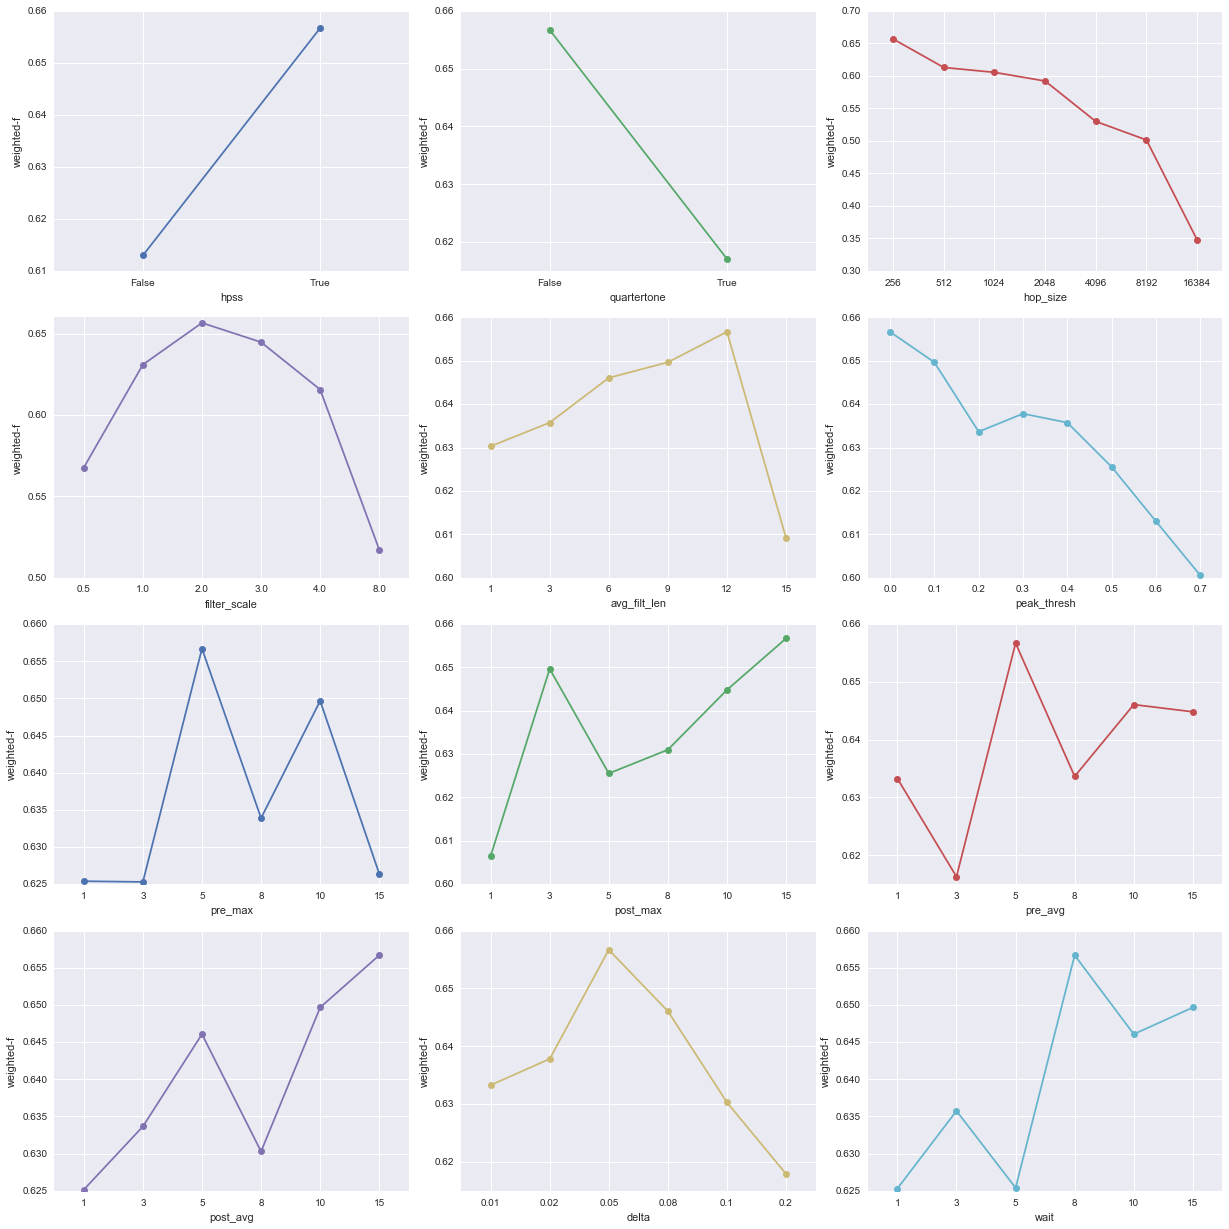

In [750]:
col = 'weighted-f'
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12 = sns.color_palette('deep', 12)
plt.figure(figsize=(17, 17))

plt.subplot(4, 3, 1)
errbar_plot(df2, 'hpss', col, color=c1)

plt.subplot(4, 3, 2)
errbar_plot(df2, 'quartertone', col, color=c2)

plt.subplot(4, 3, 3)
errbar_plot(df2, 'hop_size', col, color=c3)

plt.subplot(4, 3, 4)
errbar_plot(df2, 'filter_scale', col, color=c4)

plt.subplot(4, 3, 5)
errbar_plot(df2, 'avg_filt_len', col, color=c5)

plt.subplot(4, 3, 6)
errbar_plot(df2, 'peak_thresh', col, color=c6)

plt.subplot(4, 3, 7)
errbar_plot(df2, 'pre_max', col, color=c7)

plt.subplot(4, 3, 8)
errbar_plot(df2, 'post_max', col, color=c8)

plt.subplot(4, 3, 9)
errbar_plot(df2, 'pre_avg', col, color=c9)

plt.subplot(4, 3, 10)
errbar_plot(df2, 'post_avg', col, color=c10)

plt.subplot(4, 3, 11)
errbar_plot(df2, 'delta', col, color=c11)

plt.subplot(4, 3, 12)
errbar_plot(df2, 'wait', col, color=c12)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

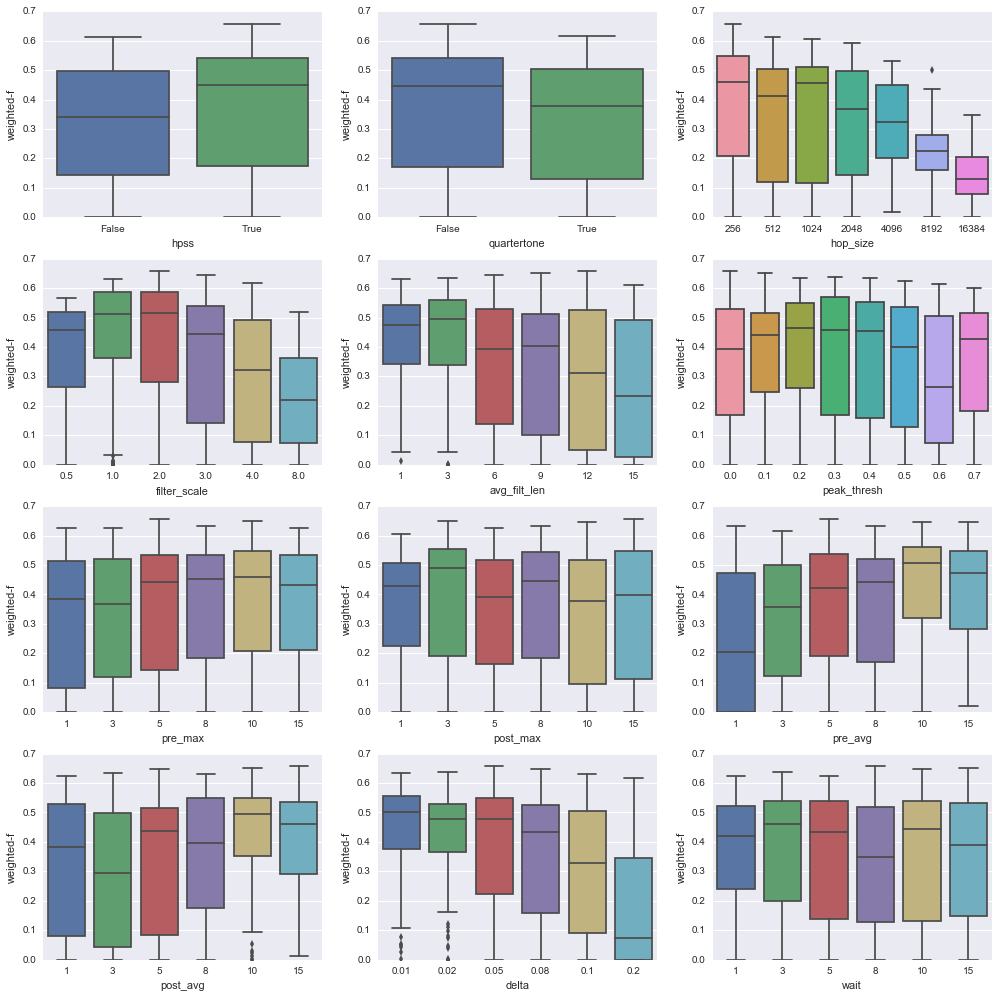

In [589]:
col = 'weighted-f'
plt.figure(figsize=(17, 17))

plt.subplot(4, 3, 1)
sns.boxplot(x='hpss', y=col, data=df2)

plt.subplot(4, 3, 2)
sns.boxplot(x='quartertone', y=col, data=df2)

plt.subplot(4, 3, 3)
sns.boxplot(x='hop_size', y=col, data=df2)

plt.subplot(4, 3, 4)
sns.boxplot(x='filter_scale', y=col, data=df2)

plt.subplot(4, 3, 5)
sns.boxplot(x='avg_filt_len', y=col, data=df2)

plt.subplot(4, 3, 6)
sns.boxplot(x='peak_thresh', y=col, data=df2)

plt.subplot(4, 3, 7)
sns.boxplot(x='pre_max', y=col, data=df2)

plt.subplot(4, 3, 8)
sns.boxplot(x='post_max', y=col, data=df2)

plt.subplot(4, 3, 9)
sns.boxplot(x='pre_avg', y=col, data=df2)

plt.subplot(4, 3, 10)
sns.boxplot(x='post_avg', y=col, data=df2)

plt.subplot(4, 3, 11)
sns.boxplot(x='delta', y=col, data=df2)

plt.subplot(4, 3, 12)
sns.boxplot(x='wait', y=col, data=df2)

In [719]:
import scipy.signal as S

def detect_seeds2(y, fs, hpss=True, quartertone=False, hop_size=4096, filter_scale=2,
                  amp_thresh=0.5, dev_thresh=2.0, norm_time=True, norm_freq=False):

    if hpss:
        y = librosa.effects.harmonic(y)

    fmin = librosa.note_to_hz('E1')
    bins_per_octave = 24 if quartertone else 12
    n_cqt_bins = bins_per_octave * 6
    cqt = np.abs(librosa.cqt(
        y, sr=fs, hop_length=hop_size, fmin=fmin, filter_scale=filter_scale,
        bins_per_octave=bins_per_octave, n_bins=n_cqt_bins,
        real=False
    ))
    
    cqt = norm_matrix(cqt, time=norm_time, freq=norm_freq).T
    
    n_time_frames = cqt.shape[0]

    freqs = librosa.cqt_frequencies(
        fmin=fmin, bins_per_octave=bins_per_octave,
        n_bins=n_cqt_bins
    )
    samples = librosa.frames_to_samples(
        range(n_time_frames), hop_length=hop_size
    )

    peaks = S.argrelmax(cqt, axis=1)
    
    cqt_thresh = np.zeros(cqt.shape)
    cqt_thresh[peaks[0], peaks[1]]  = cqt[peaks[0], peaks[1]]
    
    max_vals = np.max(cqt_thresh, axis=1)
    bad_peaks = (cqt_thresh.T < (amp_thresh * max_vals)).T
    cqt_thresh[bad_peaks] = 0
    
    mean_peak = np.mean(cqt_thresh[cqt_thresh > 0.0])
    std_peak = np.std(cqt_thresh[cqt_thresh > 0.0])

    bad_peaks = cqt_thresh < mean_peak - (dev_thresh * std_peak)
    cqt_thresh[bad_peaks] = 0
    
    new_peaks = S.argrelmax(cqt_thresh, axis=0)
    seeds = [[samples[t], freqs[i]] for t, i in zip(new_peaks[0], new_peaks[1])]

    return seeds

In [720]:
y = y_audio['MusicDelta_Country1']
seeds = detect_seeds2(y, 44100, hpss=True, quartertone=False, hop_size=1024,
                      filter_scale=3,
                      amp_thresh=0.2, dev_thresh=0.5,
                      norm_time=False, norm_freq=False)
print len(seeds)
r, p, f = evaluate_seeds(contours['MusicDelta_Country1'], seeds)
print (r, p, f)
# plt.plot([s[0] for s in seeds], [s[1] for s in seeds], 'o')

347
0.625
0.115273775216
(0.625, 0.11527377521613832, 0.5987846450274197)


In [728]:
row_data2 = []

In [771]:
for n in range(305, 1000):
    print "running iteration {}".format(n)

    recall = []
    precision = []
    f_score = []

    hpss = np.random.choice([False, True])
    quartertone = np.random.choice([False, True])
    hop_size = np.random.choice([256, 512, 1024, 2048, 4096, 8192, 16384])
    filter_scale = np.random.choice([0.5, 1, 2, 3, 4, 8])

    amp_thresh = np.random.choice([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    dev_thresh = np.random.choice([-1.0, 0.25, 0.5, 0.0, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0])
    norm_time = np.random.choice([True, False])
    norm_freq = np.random.choice([True, False])
    
    for tid in track_id_list:
        print "    {}".format(tid)
        ctr = contours[tid]
        y = y_audio[tid]
        seeds = detect_seeds2(y, 44100, hpss=hpss, quartertone=quartertone, hop_size=hop_size,
                              filter_scale=filter_scale,
                              amp_thresh=amp_thresh, dev_thresh=dev_thresh,
                              norm_time=norm_time, norm_freq=norm_freq)

        if len(seeds) > 0:
            try:
                r, p, f = evaluate_seeds(ctr, seeds)
            except ZeroDivisionError:
                r, p, f = (0.0, 0.0, 0.0)
        else:
            r, p, f = (0.0, 0.0, 0.0)

        recall.append(r)
        precision.append(p)
        f_score.append(f)
    row = [
        np.mean(recall), np.std(recall), np.mean(precision), np.std(precision),
        np.mean(f_score), np.std(f_score),
        amp_thresh, dev_thresh, norm_time, norm_freq,
        hpss, quartertone, hop_size, filter_scale
    ]
    row_data2.append(row)
    columns = [
        'recall-mean', 'recall-std', 'precision-mean', 'precision-std',
        'fscore-mean', 'fscore-std',
        'amp_thresh', 'dev_thresh', 'norm_time', 'norm_freq',
        'hpss', 'quartertone', 'hop_size', 'filter_scale'
    ]
    df = pd.DataFrame(row_data2, columns=columns)
    df.to_csv('/Users/rabitt/Dropbox/seed_data.csv')

running iteration 305
    MusicDelta_Country1
    MusicDelta_Beatles
    ClaraBerryAndWooldog_Boys
    MusicDelta_Rockabilly
    Schubert_Erstarrung
    AmarLal_SpringDay1
    LizNelson_ImComingHome
running iteration 306
    MusicDelta_Country1
    MusicDelta_Beatles
    ClaraBerryAndWooldog_Boys
    MusicDelta_Rockabilly
    Schubert_Erstarrung
    AmarLal_SpringDay1
    LizNelson_ImComingHome
running iteration 307
    MusicDelta_Country1
    MusicDelta_Beatles
    ClaraBerryAndWooldog_Boys
    MusicDelta_Rockabilly
    Schubert_Erstarrung
    AmarLal_SpringDay1
    LizNelson_ImComingHome
running iteration 308
    MusicDelta_Country1
    MusicDelta_Beatles
    ClaraBerryAndWooldog_Boys
    MusicDelta_Rockabilly
    Schubert_Erstarrung
    AmarLal_SpringDay1
    LizNelson_ImComingHome
running iteration 309
    MusicDelta_Country1
    MusicDelta_Beatles
    ClaraBerryAndWooldog_Boys
    MusicDelta_Rockabilly
    Schubert_Erstarrung
    AmarLal_SpringDay1
    LizNelson_ImComingHome
runni

In [767]:
columns = [
    'recall-mean', 'recall-std', 'precision-mean', 'precision-std',
    'fscore-mean', 'fscore-std',
    'amp_thresh', 'dev_thresh', 'norm_time', 'norm_freq',
    'hpss', 'quartertone', 'hop_size', 'filter_scale'
]
df = pd.DataFrame(row_data2, columns=columns)

In [768]:
df.describe()

,recall-mean,recall-std,precision-mean,precision-std,fscore-mean,fscore-std,amp_thresh,dev_thresh,hop_size,filter_scale
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,0.458236,0.157002,0.072985,0.040976,0.368979,0.142120,0.445902,1.365574,4649.127869,3.198361
std,0.244259,0.058872,0.049281,0.046965,0.159533,0.059211,0.293893,1.498753,5515.486235,2.543858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,256.000000,0.500000
25%,0.263931,0.127739,0.032024,0.010820,0.253554,0.097739,0.200000,0.250000,512.000000,1.000000
50%,0.430301,0.163598,0.068720,0.024406,0.392942,0.147867,0.400000,1.000000,2048.000000,2.000000
75%,0.648761,0.191576,0.104958,0.051648,0.494754,0.180294,0.700000,2.500000,8192.000000,4.000000
max,0.931617,0.315530,0.256571,0.313270,0.656004,0.295005,0.900000,4.000000,16384.000000,8.000000


In [769]:
df.ix[df['recall-mean'].argmax()]

recall-mean         0.931617
recall-std         0.0456927
precision-mean    0.00424212
precision-std     0.00201976
fscore-mean         0.279908
fscore-std         0.0906184
amp_thresh               0.1
dev_thresh                 2
norm_time               True
norm_freq               True
hpss                   False
quartertone             True
hop_size                 512
filter_scale               1
Name: 236, dtype: object

In [770]:
df.ix[df['fscore-mean'].argmax()]

recall-mean        0.823762
recall-std         0.108148
precision-mean    0.0374258
precision-std     0.0160033
fscore-mean        0.656004
fscore-std        0.0750905
amp_thresh              0.1
dev_thresh             0.25
norm_time              True
norm_freq             False
hpss                   True
quartertone           False
hop_size               2048
filter_scale              2
Name: 35, dtype: object

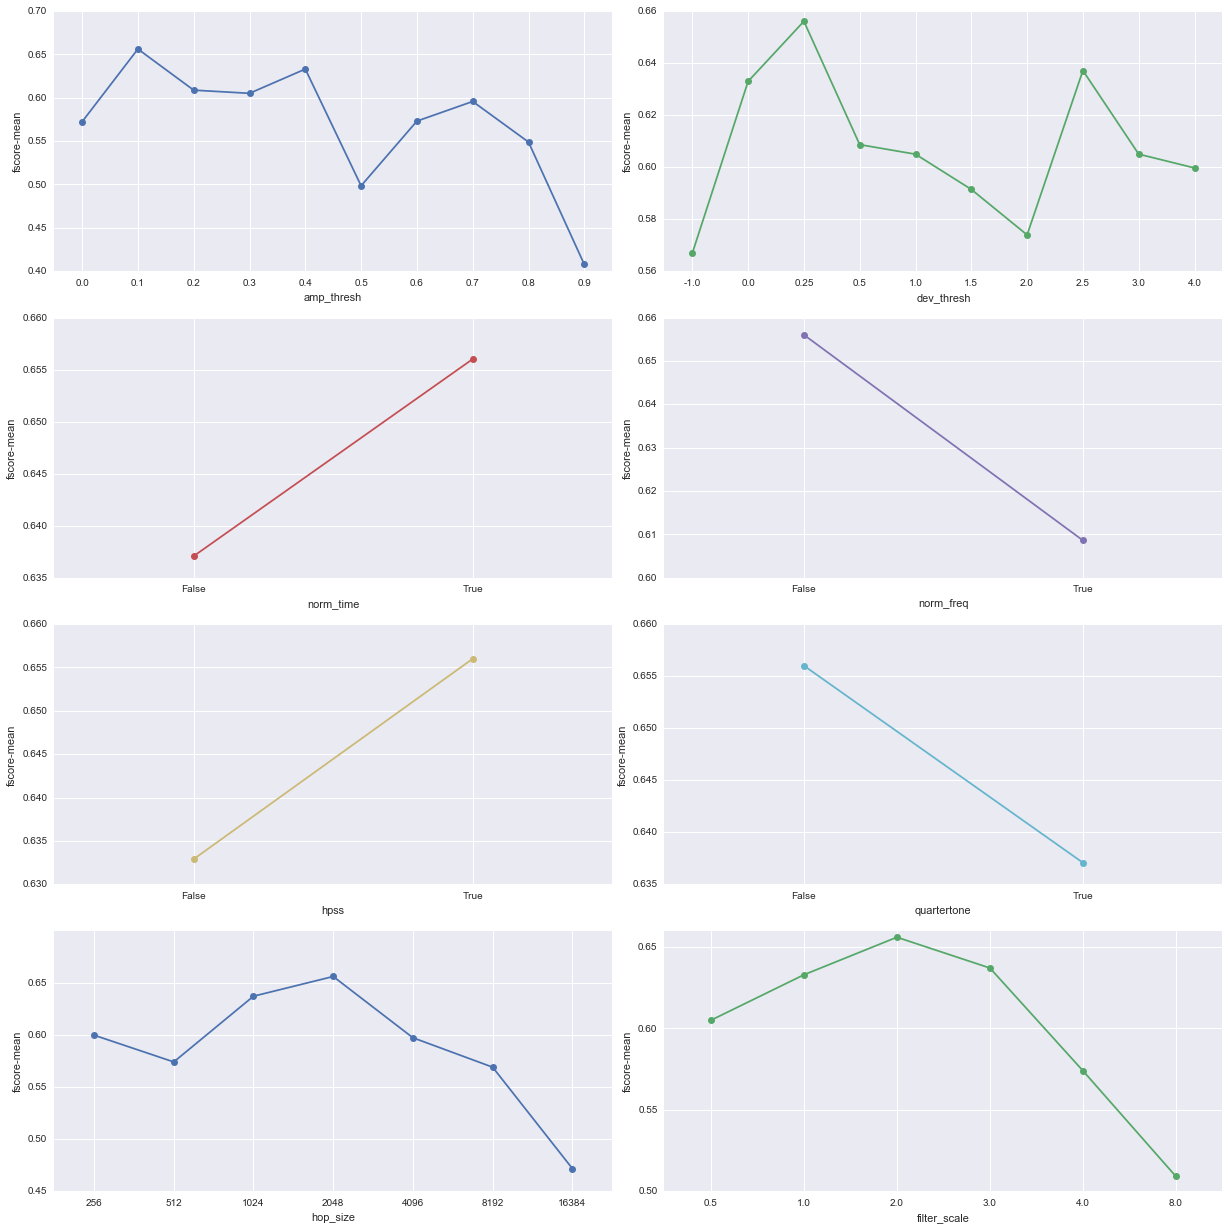

In [764]:
col = 'fscore-mean'
c1, c2, c3, c4, c5, c6, c7, c8 = sns.color_palette('deep', 8)
plt.figure(figsize=(17, 17))

plt.subplot(4, 2, 1)
errbar_plot(df, 'amp_thresh', col, color=c1)

plt.subplot(4, 2, 2)
errbar_plot(df, 'dev_thresh', col, color=c2)

plt.subplot(4, 2, 3)
errbar_plot(df, 'norm_time', col, color=c3)

plt.subplot(4, 2, 4)
errbar_plot(df, 'norm_freq', col, color=c4)

plt.subplot(4, 2, 5)
errbar_plot(df, 'hpss', col, color=c5)

plt.subplot(4, 2, 6)
errbar_plot(df, 'quartertone', col, color=c6)

plt.subplot(4, 2, 7)
errbar_plot(df, 'hop_size', col, color=c7)

plt.subplot(4, 2, 8)
errbar_plot(df, 'filter_scale', col, color=c8)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

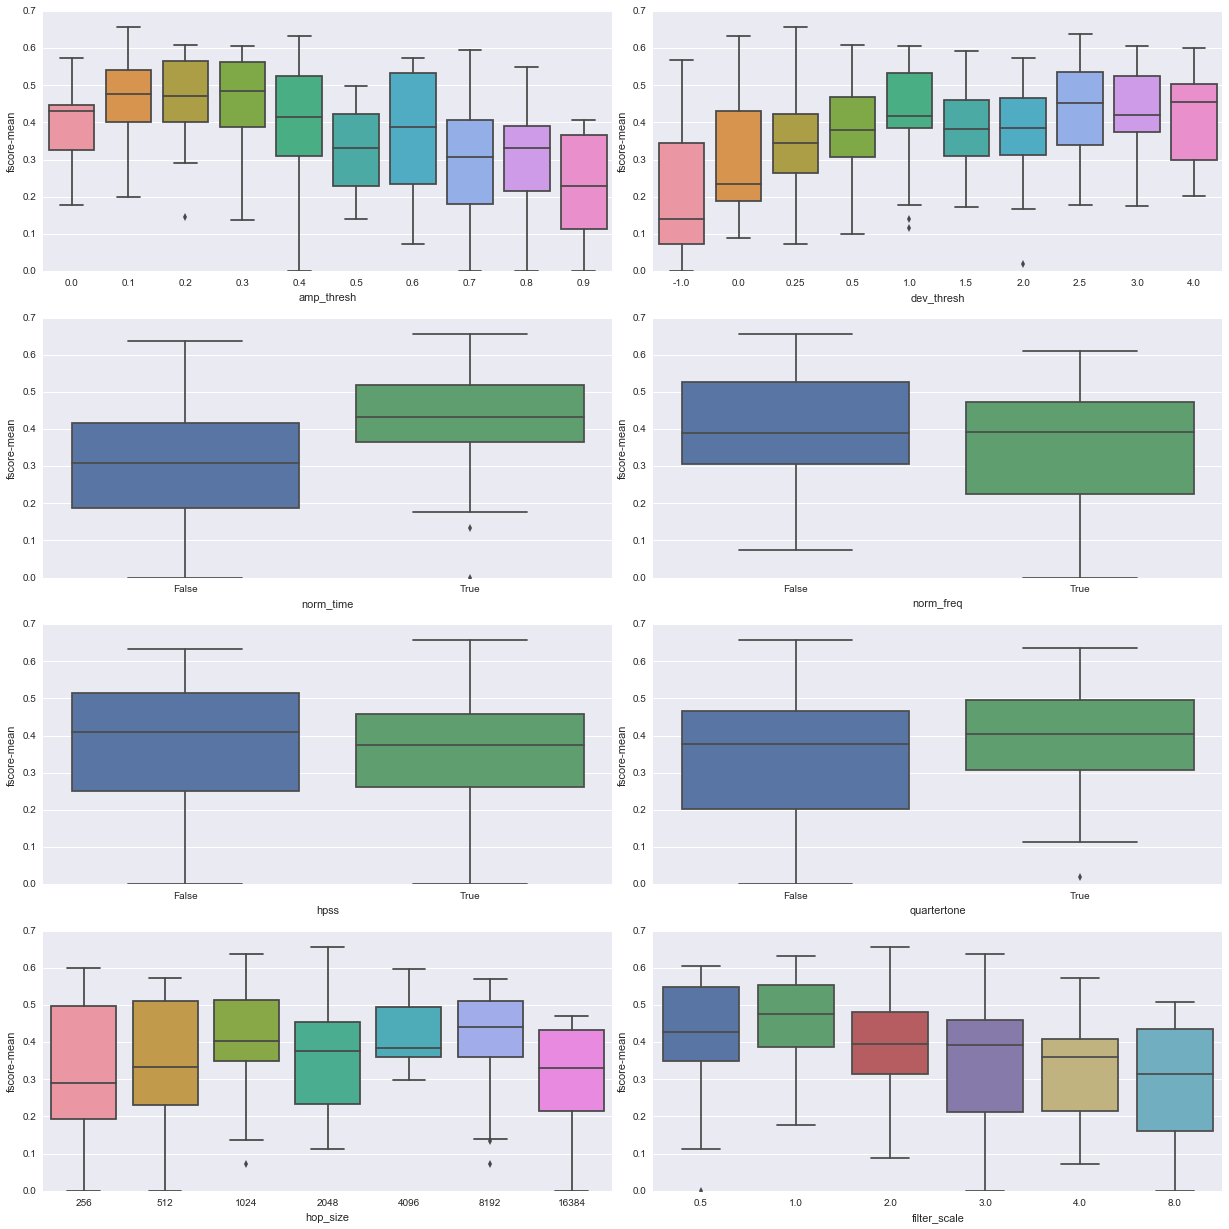

In [765]:
col = 'fscore-mean'
plt.figure(figsize=(17, 17))

plt.subplot(4, 2, 1)
sns.boxplot(data=df, x='amp_thresh', y=col)

plt.subplot(4, 2, 2)
# errbar_plot(df, 'dev_thresh', col, color=c2)
sns.boxplot(data=df, x='dev_thresh', y=col)

plt.subplot(4, 2, 3)
# errbar_plot(df, 'norm_time', col, color=c3)
sns.boxplot(data=df, x='norm_time', y=col)

plt.subplot(4, 2, 4)
# errbar_plot(df, 'norm_freq', col, color=c4)
sns.boxplot(data=df, x='norm_freq', y=col)

plt.subplot(4, 2, 5)
# errbar_plot(df, 'hpss', col, color=c5)
sns.boxplot(data=df, x='hpss', y=col)

plt.subplot(4, 2, 6)
# errbar_plot(df, 'quartertone', col, color=c6)
sns.boxplot(data=df, x='quartertone', y=col)

plt.subplot(4, 2, 7)
# errbar_plot(df, 'hop_size', col, color=c7)
sns.boxplot(data=df, x='hop_size', y=col)

plt.subplot(4, 2, 8)
# errbar_plot(df, 'filter_scale', col, color=c8)
sns.boxplot(data=df, x='filter_scale', y=col)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)